In [9]:
import pandas as pd

### Verify step 2

In [126]:
ev_vf_df = pd.read_csv('data/ev-verification.csv')
mx_vf_df = pd.read_csv('data/max-verification.csv')
gm_df = pd.read_csv('data/gemini-coding.csv')

In [136]:
# Merge on unique identifiers
merged = pd.merge(ev_vf_df, mx_vf_df, on=['transcript', 'timestamp'], suffixes=('_ev', '_mx'))

In [137]:
from sklearn.metrics import cohen_kappa_score


codes = ['c1', 'c2', 'c3', 'c4']
kappa_results = {}

for code_name in set(merged[[f'{c}_ev' for c in codes] + [f'{c}_mx' for c in codes]].values.flatten()):
    if pd.isna(code_name):
        continue
    ev_vf_list = []
    mx_vf_list = []
    for _, row in merged.iterrows():
        # Find which column in ev and mx has this code_name
        ev_code_col = next((f'{c}_ev' for c in codes if row[f'{c}_ev'] == code_name), None)
        mx_code_col = next((f'{c}_mx' for c in codes if row[f'{c}_mx'] == code_name), None)
        if ev_code_col and mx_code_col:
            ev_vf_col = ev_code_col.replace('_ev', '-vf_ev')
            mx_vf_col = mx_code_col.replace('_mx', '-vf_mx')
            ev_vf = row[ev_vf_col]
            mx_vf = row[mx_vf_col]
            if pd.notna(ev_vf) and pd.notna(mx_vf):
                ev_vf_list.append(ev_vf)
                mx_vf_list.append(mx_vf)
    if ev_vf_list and mx_vf_list:
        print(f"Calculating Cohen's kappa for code '{code_name}', number of valid entries: {len(ev_vf_list)} in ev, {len(mx_vf_list)} in mx")
        kappa = cohen_kappa_score(ev_vf_list, mx_vf_list, weights='quadratic')
        kappa_results[code_name] = kappa

for code, kappa in kappa_results.items():
    print(f"Cohen's kappa for code '{code}': {kappa}")

Calculating Cohen's kappa for code 'express agreement ', number of valid entries: 10 in ev, 10 in mx
Calculating Cohen's kappa for code 'provide supporting evidence', number of valid entries: 33 in ev, 33 in mx
Calculating Cohen's kappa for code 'ask clarifying question', number of valid entries: 18 in ev, 18 in mx
Calculating Cohen's kappa for code 'present new idea', number of valid entries: 36 in ev, 36 in mx
Calculating Cohen's kappa for code 'express alternative decision', number of valid entries: 1 in ev, 1 in mx
Calculating Cohen's kappa for code 'encourage particpatioin', number of valid entries: 7 in ev, 7 in mx
Calculating Cohen's kappa for code 'acknowledge contribution', number of valid entries: 18 in ev, 18 in mx
Calculating Cohen's kappa for code 'assign task', number of valid entries: 2 in ev, 2 in mx
Calculating Cohen's kappa for code 'express humor', number of valid entries: 1 in ev, 1 in mx
Calculating Cohen's kappa for code 'reject idea', number of valid entries: 1 i

/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * co

In [138]:
import ast

rows = []
for idx, row in gm_df.iterrows():
    ann = row['annotations']
    # Handle both dict and list of dicts, and skip NaN
    if pd.isna(ann):
        continue
    # Convert string representation to dict/list if necessary
    if isinstance(ann, str):
        try:
            ann = ast.literal_eval(ann)
        except Exception:
            continue
    if isinstance(ann, dict):
        ann_items = ann.items()
    elif isinstance(ann, list):
        ann_items = []
        for d in ann:
            if isinstance(d, dict):
                ann_items.extend(d.items())
    else:
        continue
    for key, value in ann_items:
        rows.append({
            'folder': row['folder'],
            'file': row['file'],
            'timestamp': row['timestamp'],
            'speaker': row['speaker'],
            'ai_code': key,
            'ai_explanation': value
        })

ai_ann_df = pd.DataFrame(rows, columns=['folder', 'file', 'timestamp', 'speaker', 'ai_code', 'ai_explanation'])

In [132]:
print(ai_ann_df.head())

                             folder  \
0  2021MND/output_2021_04_22_MND_S6   
1  2021MND/output_2021_04_22_MND_S6   
2  2021MND/output_2021_04_22_MND_S6   
3  2021MND/output_2021_04_22_MND_S6   
4  2021MND/output_2021_04_22_MND_S6   

                                                file      timestamp  \
0  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    00:28-00:44   
1  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    03:00-03:34   
2  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    03:00-03:34   
3  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...    01:01-02:30   
4  Breakout_Room_4_Part_2_2021_04_22_13_14_53/Bre...  [07:44-08:47]   

                speaker                            ai_code  \
0         Nandita Garud           acknowledge contribution   
1            Mark Mimee  explain or define term or concept   
2            Mark Mimee                   present new idea   
3         Nandita Garud                summarize key ideas   
4  Dr. Ali Keshavarzian     

In [141]:
print(ev_vf_df.columns)

Index(['link to video', 'timestamp', 'speaker', 'transcript', 'annotations',
       'c1', 'c1-vf', 'c1-ep', 'c2', 'c2-vf', 'c2-ep', 'c3', 'c3-vf', 'c3-ep',
       'c4', 'c4-vf', 'c4-ep', 'notes1', 'notes2'],
      dtype='object')


In [142]:
# Add new columns to ai_ann_df
ai_ann_df['ev_vf'] = None
ai_ann_df['ev_exp'] = None
ai_ann_df['mx_vf'] = None
ai_ann_df['mx_exp'] = None
ai_ann_df['link to video'] = None
ai_ann_df['ev_notes'] = None
ai_ann_df['mx_notes'] = None

for idx, ann_row in ai_ann_df.iterrows():
    ts = ann_row['timestamp']
    sp = ann_row['speaker']
    code = ann_row['ai_code']

    # Find matching row in ev_df
    ev_match = ev_vf_df[(ev_vf_df['timestamp'] == ts) & (ev_vf_df['speaker'] == sp)]
    if not ev_match.empty:
        for c in ['c1', 'c2', 'c3', 'c4']:
            if ev_match.iloc[0][c] == code:
                ai_ann_df.at[idx, 'ev_vf'] = ev_match.iloc[0][f'{c}-vf']
                ai_ann_df.at[idx, 'ev_exp'] = ev_match.iloc[0].get(f'{c}-ep', None)
                ai_ann_df.at[idx, 'link to video'] = ev_match.iloc[0].get('link to video', None)
                ai_ann_df.at[idx, 'ev_notes'] = str(ev_match.iloc[0]['notes1']) + ' ' + str(ev_match.iloc[0]['notes2'])
                break

    # Find matching row in mx_df
    mx_match = mx_vf_df[(mx_vf_df['timestamp'] == ts) & (mx_vf_df['speaker'] == sp)]
    if not mx_match.empty:
        for c in ['c1', 'c2', 'c3', 'c4']:
            if mx_match.iloc[0][c] == code:
                ai_ann_df.at[idx, 'mx_vf'] = mx_match.iloc[0][f'{c}-vf']
                ai_ann_df.at[idx, 'mx_exp'] = mx_match.iloc[0].get(f'{c}-ep', None)
                ai_ann_df.at[idx, 'mx_notes'] = str(mx_match.iloc[0]['notes1']) + ' ' + str(mx_match.iloc[0]['notes2'])
                break

In [143]:
ai_ann_df = ai_ann_df[ai_ann_df['ev_vf'].notna() & (ai_ann_df['ev_vf'] != "")]


In [ ]:
ai_ann_df.to_csv('all_anno_vf.csv', index=False)

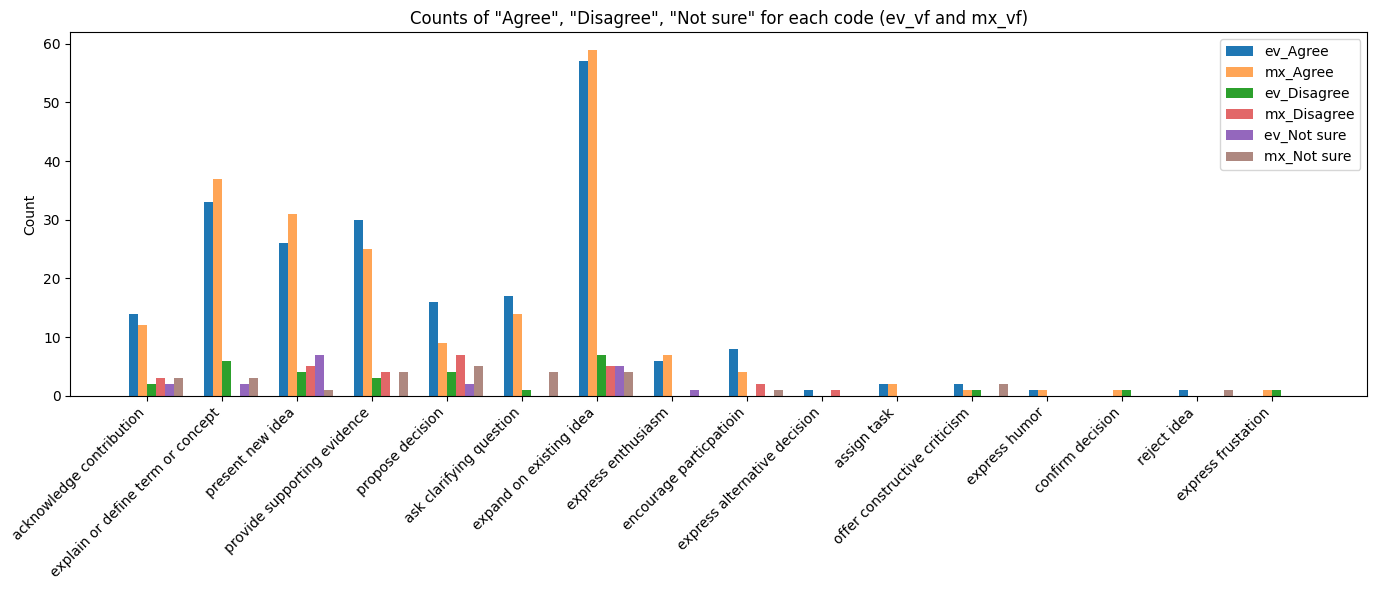

In [144]:
import matplotlib.pyplot as plt

# Get unique codes
codes = ai_ann_df['ai_code'].unique()

# Prepare a DataFrame for counts
count_data = []
for code in codes:
    subset = ai_ann_df[ai_ann_df['ai_code'] == code]
    ev_counts = subset['ev_vf'].value_counts()
    mx_counts = subset['mx_vf'].value_counts()
    count_data.append({
        'code': code,
        'ev_Agree': ev_counts.get('Agree', 0),
        
        'mx_Agree': mx_counts.get('Agree', 0),

        'ev_Disagree': ev_counts.get('Disagree', 0),
        'mx_Disagree': mx_counts.get('Disagree', 0),

        'ev_Not sure': ev_counts.get('Not sure', 0),
        'mx_Not sure': mx_counts.get('Not sure', 0),
    })

counts_df = pd.DataFrame(count_data)

# Plotting
labels = ['Agree', 'Disagree', 'Not sure']
x = range(len(codes))
width = 0.12  # Make bars a bit thinner for clarity

fig, ax = plt.subplots(figsize=(14, 6))

for i, label in enumerate(labels):
    # Plot ev and mx side by side for each label
    ax.bar([p + i*2*width for p in x], counts_df[f'ev_{label}'], width, label=f'ev_{label}')
    ax.bar([p + (i*2+1)*width for p in x], counts_df[f'mx_{label}'], width, label=f'mx_{label}', alpha=0.7)

ax.set_xticks([p + 1.5*width for p in x])
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Counts of "Agree", "Disagree", "Not sure" for each code (ev_vf and mx_vf)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa_by_code = {}

for code in ai_ann_df['ai_code'].unique():
    subset = ai_ann_df[ai_ann_df['ai_code'] == code]
    ev_vf = subset['ev_vf']
    mx_vf = subset['mx_vf']
    # Only keep rows where both are not null/empty
    valid = subset[ev_vf.notna() & mx_vf.notna() & (ev_vf != "") & (mx_vf != "")]
    if not valid.empty:
        print(f"Calculating Cohen's kappa for code '{code}', number of valid entries: {len(valid)}")
        kappa = cohen_kappa_score(valid['ev_vf'], valid['mx_vf'], weights='quadratic')
        kappa_by_code[code] = kappa

for code, kappa in kappa_by_code.items():
    print(f"Cohen's kappa for code '{code}': {kappa}")

Calculating Cohen's kappa for code 'acknowledge contribution', number of valid entries: 18
Calculating Cohen's kappa for code 'explain or define term or concept', number of valid entries: 40
Calculating Cohen's kappa for code 'present new idea', number of valid entries: 37
Calculating Cohen's kappa for code 'provide supporting evidence', number of valid entries: 33
Calculating Cohen's kappa for code 'propose decision', number of valid entries: 21
Calculating Cohen's kappa for code 'ask clarifying question', number of valid entries: 18
Calculating Cohen's kappa for code 'expand on existing idea', number of valid entries: 68
Calculating Cohen's kappa for code 'express enthusiasm', number of valid entries: 7
Calculating Cohen's kappa for code 'encourage particpatioin', number of valid entries: 7
Calculating Cohen's kappa for code 'express alternative decision', number of valid entries: 1
Calculating Cohen's kappa for code 'assign task', number of valid entries: 2
Calculating Cohen's kappa

/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/eveyhuang/Documents/NICO/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * co

In [152]:
# Calculate simple agreement for each unique code in ai_ann_df['ai_code']
simple_agreement = {}

for code in ai_ann_df['ai_code'].unique():
    subset = ai_ann_df[ai_ann_df['ai_code'] == code]
    # Only keep rows where both are not null/empty
    valid = subset[subset['ev_vf'].notna() & subset['mx_vf'].notna() & (subset['ev_vf'] != "") & (subset['mx_vf'] != "")]
    if not valid.empty:
        agreement = (valid['ev_vf'] == valid['mx_vf']).mean()
        simple_agreement[code] = agreement

for code, agreement in simple_agreement.items():
    print(f"Simple agreement for code '{code}': {agreement:.3f}")

Simple agreement for code 'acknowledge contribution': 0.667
Simple agreement for code 'explain or define term or concept': 0.825
Simple agreement for code 'present new idea': 0.649
Simple agreement for code 'provide supporting evidence': 0.727
Simple agreement for code 'propose decision': 0.476
Simple agreement for code 'ask clarifying question': 0.778
Simple agreement for code 'expand on existing idea': 0.735
Simple agreement for code 'express enthusiasm': 0.857
Simple agreement for code 'encourage particpatioin': 0.571
Simple agreement for code 'express alternative decision': 0.000
Simple agreement for code 'assign task': 1.000
Simple agreement for code 'offer constructive criticism': 0.333
Simple agreement for code 'express humor': 1.000
Simple agreement for code 'confirm decision': 0.000
Simple agreement for code 'reject idea': 0.000
Simple agreement for code 'express frustation': 0.000


In [151]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import numpy as np

pabak_by_code_ev_mx_vf = {}

def pabak_from_confmat(cm):
    # cm: confusion matrix [[TN, FP], [FN, TP]]
    total = cm.sum()
    a = cm[0, 0]   
    b = cm[0, 1] 
    c = cm[1, 0] 
    d = cm[1, 1]

    BI = (b-c)/total
    PI = (a-d)/total
    if total == 0:
        return np.nan
    observed_agreement = (a+d) / total
    pabak = 2 * observed_agreement - 1
    k = (pabak - PI**2 + BI**2) / (1 - PI**2 + BI**2)
    return BI, PI, pabak, k

for code in ai_ann_df['ai_code'].unique():
    subset = ai_ann_df[ai_ann_df['ai_code'] == code]
    # Only keep rows where both are not null/empty
    valid = subset[subset['ev_vf'].notna() & subset['mx_vf'].notna() & (subset['ev_vf'] != "") & (subset['mx_vf'] != "")]
    if not valid.empty:
        # Convert to binary: 1 if 'Agree', 0 otherwise (or you can use all categories if needed)
       
        agreement = (valid['ev_vf'] == valid['mx_vf']).mean()
        print(f"Simple agreement: {agreement:.3f}")
        pabak = 2 * agreement - 1

        pabak_by_code_ev_mx_vf[code] = pabak

for code, pabak in pabak_by_code_ev_mx_vf.items():
    print(f"PABAK for code '{code}': {pabak:.3f}")

Simple agreement: 0.667
Simple agreement: 0.825
Simple agreement: 0.649
Simple agreement: 0.727
Simple agreement: 0.476
Simple agreement: 0.778
Simple agreement: 0.735
Simple agreement: 0.857
Simple agreement: 0.571
Simple agreement: 0.000
Simple agreement: 1.000
Simple agreement: 0.333
Simple agreement: 1.000
Simple agreement: 0.000
Simple agreement: 0.000
Simple agreement: 0.000
PABAK for code 'acknowledge contribution': 0.333
PABAK for code 'explain or define term or concept': 0.650
PABAK for code 'present new idea': 0.297
PABAK for code 'provide supporting evidence': 0.455
PABAK for code 'propose decision': -0.048
PABAK for code 'ask clarifying question': 0.556
PABAK for code 'expand on existing idea': 0.471
PABAK for code 'express enthusiasm': 0.714
PABAK for code 'encourage particpatioin': 0.143
PABAK for code 'express alternative decision': -1.000
PABAK for code 'assign task': 1.000
PABAK for code 'offer constructive criticism': -0.333
PABAK for code 'express humor': 1.000
PABAK

In [154]:
# Create a DataFrame to display kappa scores and simple agreement scores
scores_table = pd.DataFrame({
    'Code': simple_agreement.keys(),
    'Simple Agreement': simple_agreement.values(),
    'PABAK': pabak_by_code_ev_mx_vf.values(),
})

# apply gradient to the cell backgrounds
styled_table = (scores_table.round(3)).style.background_gradient(cmap='RdYlGn')

styled_table

,Code,Simple Agreement,PABAK
0,acknowledge contribution,0.667000,0.333000
1,explain or define term or concept,0.825000,0.650000
2,present new idea,0.649000,0.297000
3,provide supporting evidence,0.727000,0.455000
4,propose decision,0.476000,-0.048000
5,ask clarifying question,0.778000,0.556000
6,expand on existing idea,0.735000,0.471000
7,express enthusiasm,0.857000,0.714000
8,encourage particpatioin,0.571000,0.143000
9,express alternative decision,0.000000,-1.000000


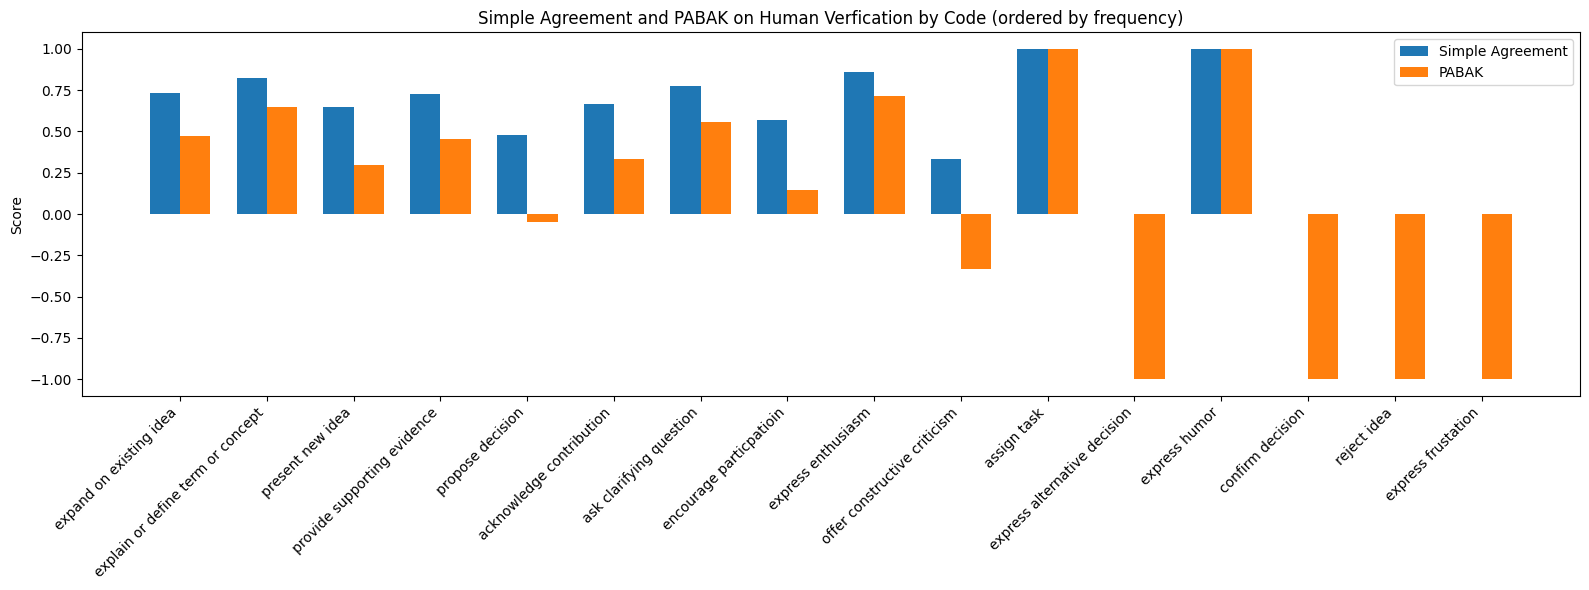

In [ ]:
# Count frequency of each code in ai_ann_df
code_freq = ai_ann_df['ai_code'].value_counts()

# Reindex scores_table to match frequency order
ordered_codes = code_freq.index.tolist()
scores_table_ordered = scores_table.set_index('Code').loc[ordered_codes].reset_index()

codes = scores_table_ordered['Code']
simple_agreement = scores_table_ordered['Simple Agreement']
pabak = scores_table_ordered['PABAK']

x = range(len(codes))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x, simple_agreement, width, label='Simple Agreement')
ax.bar([i + width for i in x], pabak, width, label='PABAK')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Simple Agreement and PABAK on Human Verfication by Code (ordered by frequency)')
ax.legend()
plt.tight_layout()
plt.show()

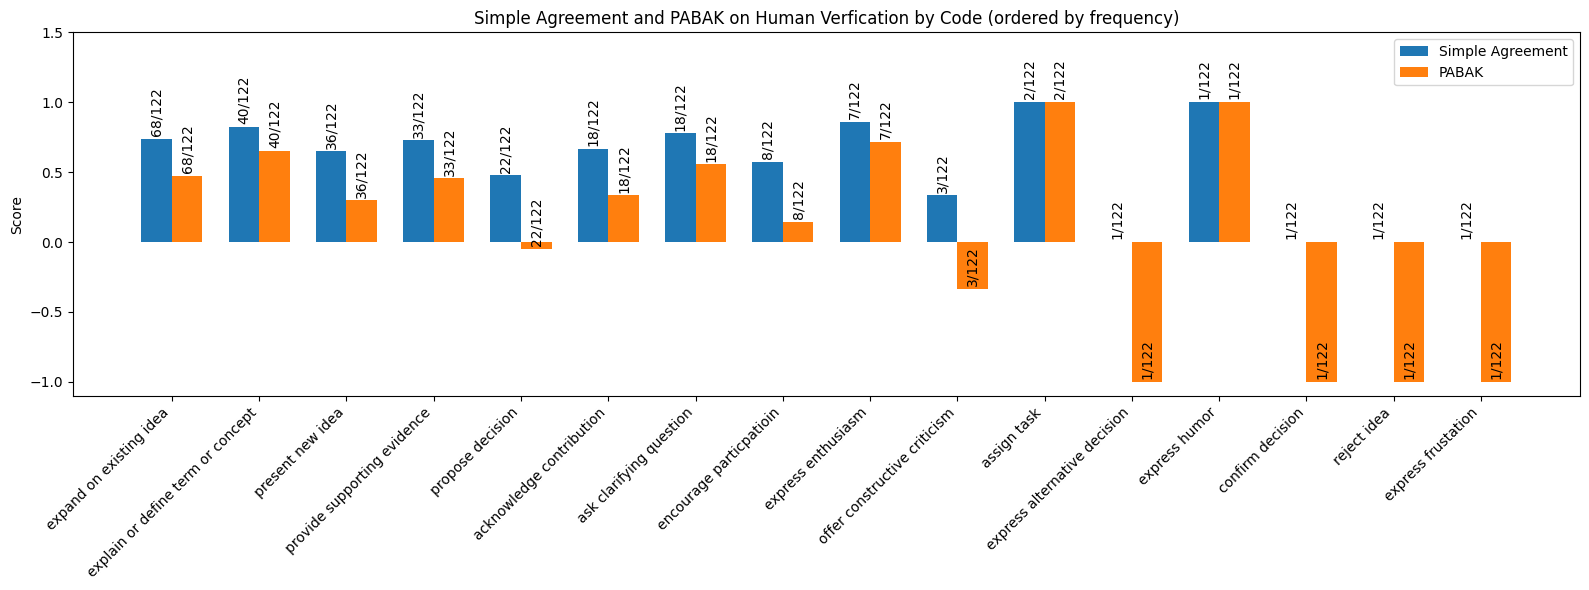

<Figure size 640x480 with 0 Axes>

In [171]:
# Calculate total unique (file, timestamp) pairs
total_file_ts = ai_ann_df[['file', 'timestamp']].drop_duplicates().shape[0]

# Calculate unique (file, timestamp) pairs for each code (across all raters)
code_file_ts_counts = {}
for code in codes:
    count = ai_ann_df[ai_ann_df['ai_code'] == code][['file', 'timestamp']].drop_duplicates().shape[0]
    code_file_ts_counts[code] = count


scores_table_ordered = scores_table.set_index('Code').loc[ordered_codes].reset_index()

codes = scores_table_ordered['Code']
simple_agreement = scores_table_ordered['Simple Agreement']
pabak = scores_table_ordered['PABAK']

x = range(len(codes))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x, simple_agreement, width, label='Simple Agreement')
ax.bar([i + width for i in x], pabak, width, label='PABAK')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_ylim(top=1.5)
ax.set_title('Simple Agreement and PABAK on Human Verfication by Code (ordered by frequency)')
ax.legend()

# Annotate each bar with count/total_file_ts
for i, code in enumerate(codes):
    count = code_file_ts_counts[code]
    # Annotate Simple Agreement bar
    ax.text(i, simple_agreement.iloc[i] + 0.02, f"{count}/{total_file_ts}", 
            ha='center', va='bottom', fontsize=10, color='black', rotation=90)
    # Annotate PABAK bar
    ax.text(i + width, pabak.iloc[i] + 0.02, f"{count}/{total_file_ts}", 
            ha='center', va='bottom', fontsize=10, color='black', rotation=90)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [ ]:
# Count rows where both ev_vf and mx_vf are 'Disagree'
both_disagree = ai_ann_df[(ai_ann_df['ev_vf'] == 'Disagree') & (ai_ann_df['mx_vf'] == 'Disagree')]
num_both_disagree = len(both_disagree)
total_rows = len(ai_ann_df)
percentage = (num_both_disagree / total_rows) * 100 if total_rows > 0 else 0

print(f"Number of rows where both ev_vf and mx_vf are 'Disagree': {num_both_disagree}")
print(f"Percentage of such rows: {percentage:.2f}%")
both_disagree.to_excel('both_disagree.xlsx', index=False)

Number of rows where both ev_vf and mx_vf are 'Disagree': 7
Percentage of such rows: 2.66%


In [ ]:
# Find codes with simple agreement score equal to zero
zero_agreement_codes = [code for code, score in simple_agreement.items() if score <= 0.6]

# Filter ai_ann_df for those codes
zero_agreement_rows = ai_ann_df[ai_ann_df['ai_code'].isin(zero_agreement_codes)]
zero_agreement_rows.to_excel('low_agreement_rows.xlsx', index=False)

In [ ]:
# Count rows where either ev_vf or mx_vf is 'Disagree'
either_disagree = ai_ann_df[(ai_ann_df['ev_vf'] == 'Disagree') | (ai_ann_df['mx_vf'] == 'Disagree')]
num_either_disagree = len(either_disagree)
total_rows = len(ai_ann_df)
percentage = (num_either_disagree / total_rows) * 100 if total_rows > 0 else 0

print(f"Number of rows where either ev_vf and mx_vf are 'Disagree': {num_either_disagree}")
print(f"Percentage of such rows: {percentage:.2f}%")
either_disagree.to_excel('either_disagree.xlsx', index=False)

Number of rows where either ev_vf and mx_vf are 'Disagree': 50
Percentage of such rows: 19.01%


### Check agreements on annotations

In [109]:
from sklearn.metrics import confusion_matrix
import numpy as np


def pabak_from_confmat(cm):
    # cm: confusion matrix [[TN, FP], [FN, TP]]
    total = cm.sum()
    a = cm[0, 0]   
    b = cm[0, 1] 
    c = cm[1, 0] 
    d = cm[1, 1]

    BI = (b-c)/total
    PI = (a-d)/total
    if total == 0:
        return np.nan
    observed_agreement = (a+d) / total
    pabak = 2 * observed_agreement - 1
    k = (pabak - PI**2 + BI**2) / (1 - PI**2 + BI**2)
    return BI, PI, pabak, k

In [71]:
ev_df = pd.read_csv('data/ev-annotation.csv')
mx_df = pd.read_csv('data/mx-annotation.csv')
gm_df = pd.read_csv('data/gemini-coding.csv')

In [74]:
import ast

rows = []
for idx, row in gm_df.iterrows():
    ann = row['annotations']
    # Handle both dict and list of dicts, and skip NaN
    if pd.isna(ann):
        continue
    # Convert string representation to dict/list if necessary
    if isinstance(ann, str):
        try:
            ann = ast.literal_eval(ann)
        except Exception:
            continue
    if isinstance(ann, dict):
        ann_items = ann.items()
    elif isinstance(ann, list):
        ann_items = []
        for d in ann:
            if isinstance(d, dict):
                ann_items.extend(d.items())
    else:
        continue
    for key, value in ann_items:
        if key == 'summarize key ideas':
            # Skip this key as per the requirement
            continue
        # print(f"Processing annotation: {key} with value: {value}")
        rows.append({
            'folder': row['folder'],
            'file': row['file'],
            'timestamp': row['timestamp'],
            'speaker': row['speaker'],
            'coder': 'gemini',
            'code': key,
            'explanation': value
        })

ai_ann_df = pd.DataFrame(rows, columns=['folder', 'file', 'timestamp', 'speaker', 'coder', 'code', 'explanation'])

In [92]:
all_ann_df = ai_ann_df.copy()

def add_coder_rows(source_df, coder_label):
    new_rows = []
    for _, row in source_df.iterrows():
        for num in range(1, 5):
            code_col = f'c{num}'
            exp_col = f'c{num}-ep' if f'c{num}-ep' in row else f'c{num}-ep'
            code = row.get(code_col, None)
            exp = row.get(exp_col, None)
            if pd.notna(code) and code != "":
                # Find file from all_ann_df with same timestamp and speaker
                match = all_ann_df[(all_ann_df['timestamp'] == row['timestamp']) & (all_ann_df['speaker'] == row['speaker'])]
                file_val = match['file'].iloc[0] if not match.empty else None
                if code == "NA (please provide explanation)":
                    continue
                new_rows.append({
                    'folder': None,
                    'file': file_val,
                    'timestamp': row['timestamp'],
                    'speaker': row['speaker'],
                    'coder': coder_label,
                    'code': code,
                    'explanation': exp
                })
    return new_rows

ev_rows = add_coder_rows(ev_df, 'ev')
mx_rows = add_coder_rows(mx_df, 'mx')

# Append to all_ann_df
all_ann_df = pd.concat([all_ann_df, pd.DataFrame(ev_rows + mx_rows)], ignore_index=True)

In [79]:
print("Number of rows where coder == 'gemini':", (all_ann_df['coder'] == 'gemini').sum())
print("Number of rows where coder == 'ev':", (all_ann_df['coder'] == 'ev').sum())
print("Number of rows where coder == 'mx':", (all_ann_df['coder'] == 'mx').sum())

Number of rows where coder == 'gemini': 330
Number of rows where coder == 'ev': 242
Number of rows where coder == 'mx': 190


In [93]:
# Create a mapping from unique 'file' values to unique integer ids
file_to_id = {file: idx for idx, file in enumerate(all_ann_df['file'].astype(str).unique())}
all_ann_df['id'] = all_ann_df['file'].astype(str).map(file_to_id)

In [82]:
print("Number of unique values in all_ann_df['id']:", all_ann_df['id'].nunique())
print("Number of rows in ev_df:", len(ev_df))
print("Number of rows in mx_df:", len(mx_df))
print("Number of rows in gm_df:", len(gm_df))

Number of unique values in all_ann_df['id']: 53
Number of rows in ev_df: 129
Number of rows in mx_df: 129
Number of rows in gm_df: 157


In [94]:
# Filter out ids where there are no rows with coder == 'ev' because there were some videos that were not watched by the human coders
ids_with_ev = all_ann_df[all_ann_df['coder'] == 'ev']['id'].unique()
filtered_ann_df = all_ann_df[all_ann_df['id'].isin(ids_with_ev)].copy()
num_missing_ids = len(set(all_ann_df['id']) - set(filtered_ann_df['id']))
print(f"Number of ids in all_ann_df but not in filtered_ann_df: {num_missing_ids}")

Number of ids in all_ann_df but not in filtered_ann_df: 12


##### agreement between evey and max

In [120]:
evmx_pabak = {}

all_ids = filtered_ann_df['id'].unique()
all_codes = filtered_ann_df['code'].unique()

for code in all_codes:
    y_ev = []
    y_mx = []
    for id_ in all_ids:
        # For each coder, does this id have this code?
        ev_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'ev') & (filtered_ann_df['code'] == code)).any()
        mx_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'mx') & (filtered_ann_df['code'] == code)).any()
        y_ev.append(int(ev_has))
        y_mx.append(int(mx_has))
    # Now y_ev and y_mx are binary vectors for this code
    cm = confusion_matrix(y_ev, y_mx, labels=[0,1])
    bi, pi, pabak, k = pabak_from_confmat(cm)
    evmx_pabak[code] = [bi, pi, pabak, k] 

for code, values in evmx_pabak.items():
    print(f"PABAK for code '{code}': {values[2]:.3f}")
    print(f"K for code '{code}': {values[3]:.3f}")

PABAK for code 'acknowledge contribution': 0.366
K for code 'acknowledge contribution': 0.301
PABAK for code 'explain or define term or concept': 0.268
K for code 'explain or define term or concept': 0.300
PABAK for code 'present new idea': -0.024
K for code 'present new idea': -0.114
PABAK for code 'provide supporting evidence': 0.268
K for code 'provide supporting evidence': 0.322
PABAK for code 'propose decision': 0.317
K for code 'propose decision': 0.196
PABAK for code 'ask clarifying question': 0.317
K for code 'ask clarifying question': 0.293
PABAK for code 'expand on existing idea': 0.171
K for code 'expand on existing idea': 0.028
PABAK for code 'express enthusiasm': 0.366
K for code 'express enthusiasm': -0.177
PABAK for code 'encourage particpatioin': 0.561
K for code 'encourage particpatioin': 0.272
PABAK for code 'express agreement': 0.707
K for code 'express agreement': 0.534
PABAK for code 'express alternative decision': 0.805
K for code 'express alternative decision': -

/var/folders/17/4vnbnj_12zv7szz7s0jq3dj80000gn/T/ipykernel_4536/2517105094.py:19: RuntimeWarning: invalid value encountered in scalar divide
  k = (pabak - PI**2 + BI**2) / (1 - PI**2 + BI**2)


#### agreement between ev and gemini

In [121]:
evgm_pabak = {}

for code in all_codes:
    y_ev = []
    y_gm = []
    for id_ in all_ids:
        # For each coder, does this id have this code?
        ev_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'ev') & (filtered_ann_df['code'] == code)).any()
        gm_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'gemini') & (filtered_ann_df['code'] == code)).any()
        y_ev.append(int(ev_has))
        y_gm.append(int(gm_has))
    # Now y_ev and y_mx are binary vectors for this code
    cm = confusion_matrix(y_ev, y_gm, labels=[0,1])
    bi, pi, pabak, k = pabak_from_confmat(cm)
    evgm_pabak[code] = [bi, pi, pabak, k] 

for code, values in evgm_pabak.items():
    print(f"PABAK for code '{code}': {values[2]:.3f}")
    print(f"K for code '{code}': {values[3]:.3f}")

PABAK for code 'acknowledge contribution': 0.463
K for code 'acknowledge contribution': 0.445
PABAK for code 'explain or define term or concept': 0.268
K for code 'explain or define term or concept': 0.240
PABAK for code 'present new idea': -0.024
K for code 'present new idea': 0.097
PABAK for code 'provide supporting evidence': 0.317
K for code 'provide supporting evidence': 0.320
PABAK for code 'propose decision': 0.756
K for code 'propose decision': 0.733
PABAK for code 'ask clarifying question': 0.610
K for code 'ask clarifying question': 0.530
PABAK for code 'expand on existing idea': 0.463
K for code 'expand on existing idea': 0.347
PABAK for code 'express enthusiasm': 0.317
K for code 'express enthusiasm': -0.087
PABAK for code 'encourage particpatioin': 0.610
K for code 'encourage particpatioin': 0.381
PABAK for code 'express agreement': 0.659
K for code 'express agreement': 0.481
PABAK for code 'express alternative decision': 0.805
K for code 'express alternative decision': -0

#### agreement between max and gemini

In [122]:
mxgm_pabak = {}

for code in all_codes:
    y_mx = []
    y_gm = []
    for id_ in all_ids:
        # For each coder, does this id have this code?
        mx_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'mx') & (filtered_ann_df['code'] == code)).any()
        gm_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'gemini') & (filtered_ann_df['code'] == code)).any()
        y_mx.append(int(mx_has))
        y_gm.append(int(gm_has))
    # Now y_ev and y_mx are binary vectors for this code
    cm = confusion_matrix(y_mx, y_gm, labels=[0,1])
    bi, pi, pabak, k = pabak_from_confmat(cm)
    mxgm_pabak[code] = [bi, pi, pabak, k] 

for code, values in mxgm_pabak.items():
    print(f"PABAK for code '{code}': {values[2]:.3f}")
    print(f"K for code '{code}': {values[3]:.3f}")

PABAK for code 'acknowledge contribution': 0.317
K for code 'acknowledge contribution': 0.143
PABAK for code 'explain or define term or concept': -0.073
K for code 'explain or define term or concept': -0.013
PABAK for code 'present new idea': -0.171
K for code 'present new idea': -0.084
PABAK for code 'provide supporting evidence': 0.171
K for code 'provide supporting evidence': 0.161
PABAK for code 'propose decision': 0.268
K for code 'propose decision': 0.110
PABAK for code 'ask clarifying question': 0.317
K for code 'ask clarifying question': 0.298
PABAK for code 'expand on existing idea': 0.317
K for code 'expand on existing idea': 0.077
PABAK for code 'express enthusiasm': 0.561
K for code 'express enthusiasm': 0.185
PABAK for code 'encourage particpatioin': 0.756
K for code 'encourage particpatioin': 0.543
PABAK for code 'express agreement': 0.854
K for code 'express agreement': 0.778
PABAK for code 'express alternative decision': 0.902
K for code 'express alternative decision': 

In [100]:
ai_vs_human_union_pabak = {}

for code in all_codes:
    y_human = []
    y_gm = []
    for id_ in all_ids:
        # Human union: 1 if either ev or mx assigned this code to this id
        ev_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'ev') & (filtered_ann_df['code'] == code)).any()
        mx_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'mx') & (filtered_ann_df['code'] == code)).any()
        human_has = ev_has or mx_has
        gm_has = ((filtered_ann_df['id'] == id_) & (filtered_ann_df['coder'] == 'gemini') & (filtered_ann_df['code'] == code)).any()
        y_human.append(int(human_has))
        y_gm.append(int(gm_has))
    cm = confusion_matrix(y_human, y_gm, labels=[0,1])
    bi, pi, k = pabak_from_confmat(cm)
    ai_vs_human_union_pabak[code] = [bi, pi, k]

for code, values in ai_vs_human_union_pabak.items():
    print(f"PABAK for code '{code}' (AI vs. human union): {values[2]:.3f}")
    print(f"BI for code '{code}': {values[0]:.3f}")
    print(f"PI for code '{code}': {values[1]:.3f}")

PABAK for code 'provide supporting evidence' (AI vs. human union): 0.369
BI for code 'provide supporting evidence': -0.122
PI for code 'provide supporting evidence': -0.098
PABAK for code 'ask clarifying question' (AI vs. human union): 0.287
BI for code 'ask clarifying question': -0.220
PI for code 'ask clarifying question': 0.146
PABAK for code 'express alternative decision' (AI vs. human union): -0.041
BI for code 'express alternative decision': -0.073
PI for code 'express alternative decision': 0.878
PABAK for code 'assign task' (AI vs. human union): 0.655
BI for code 'assign task': 0.024
PI for code 'assign task': 0.927
PABAK for code 'expand on existing idea' (AI vs. human union): 0.377
BI for code 'expand on existing idea': -0.122
PI for code 'expand on existing idea': -0.683
PABAK for code 'explain or define term or concept' (AI vs. human union): 0.161
BI for code 'explain or define term or concept': -0.049
PI for code 'explain or define term or concept': -0.268
PABAK for code '

In [123]:
import pandas as pd
import numpy as np

# Collect all unique codes from the three dictionaries
all_codes = set(evmx_pabak.keys()) | set(evgm_pabak.keys()) | set(mxgm_pabak.keys())

# Build the table
pabak_table = pd.DataFrame({
    'Code': list(all_codes),
    'ev-mx': [evmx_pabak.get(code, [np.nan, np.nan, np.nan, np.nan])[2] for code in all_codes],
    'ev-ai': [evgm_pabak.get(code, [np.nan, np.nan, np.nan, np.nan])[2] for code in all_codes],
    'mx-ai': [mxgm_pabak.get(code, [np.nan, np.nan, np.nan, np.nan])[2] for code in all_codes]
})

# Style the table with a diverging colormap
styled_pabak = pabak_table.set_index('Code').style.background_gradient(
    cmap='RdYlGn', axis=None, vmin=-1, vmax=1
).format("{:.3f}")

styled_pabak

,ev-mx,ev-ai,mx-ai
Code,,,
provide supporting evidence,0.268,0.317,0.171
ask clarifying question,0.317,0.610,0.317
express alternative decision,0.805,0.805,0.902
assign task,0.951,0.902,0.951
expand on existing idea,0.171,0.463,0.317
explain or define term or concept,0.268,0.268,-0.073
express agreement,0.707,0.659,0.854
confirm decision,1.000,0.951,0.951
present new idea,-0.024,-0.024,-0.171


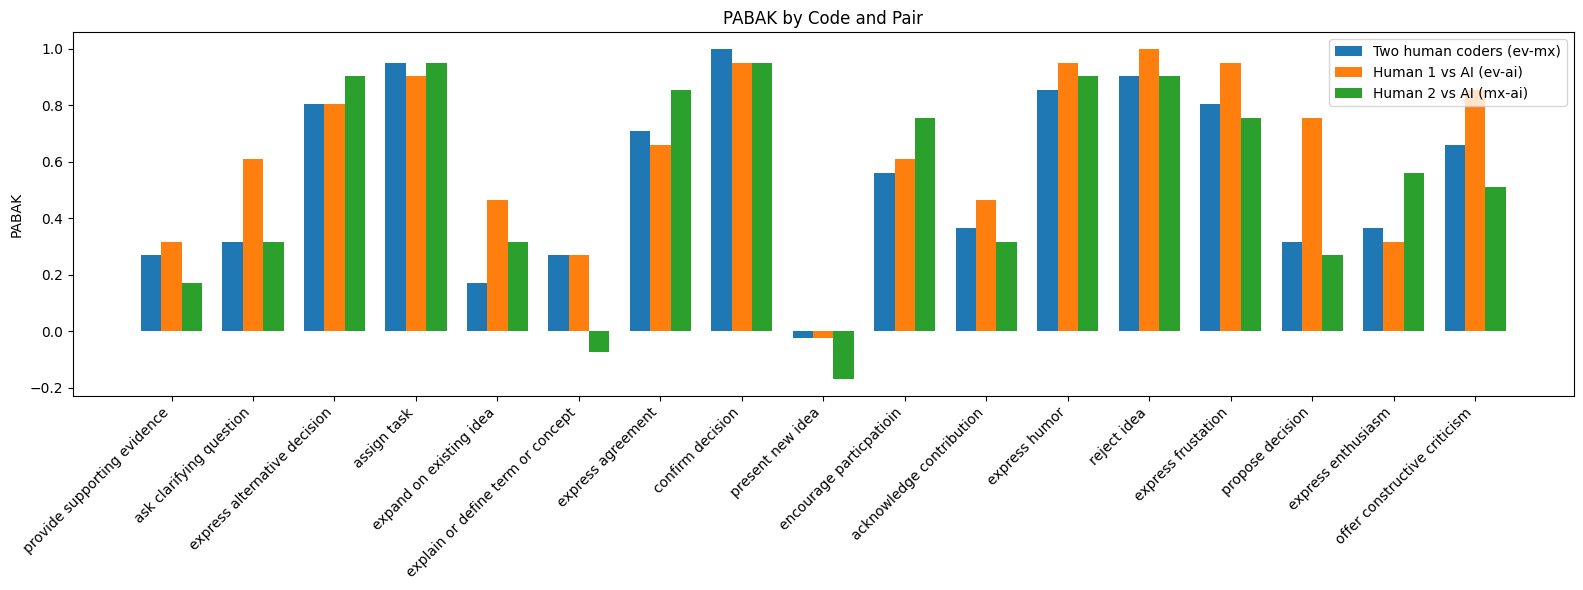

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Prepare data
codes = pabak_table['Code']
ev_mx = pabak_table['ev-mx']
ev_ai = pabak_table['ev-ai']
mx_ai = pabak_table['mx-ai']

x = np.arange(len(codes))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6)) 

bar1 = ax.bar(x - width, ev_mx, width, label='Two human coders (ev-mx)')
bar2 = ax.bar(x, ev_ai, width, label='Human 1 vs AI (ev-ai)')
bar3 = ax.bar(x + width, mx_ai, width, label='Human 2 vs AI (mx-ai)')

ax.set_xticks(x)
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('PABAK')
ax.set_title('PABAK by Code and Pair')
ax.legend()
plt.tight_layout()
plt.show()

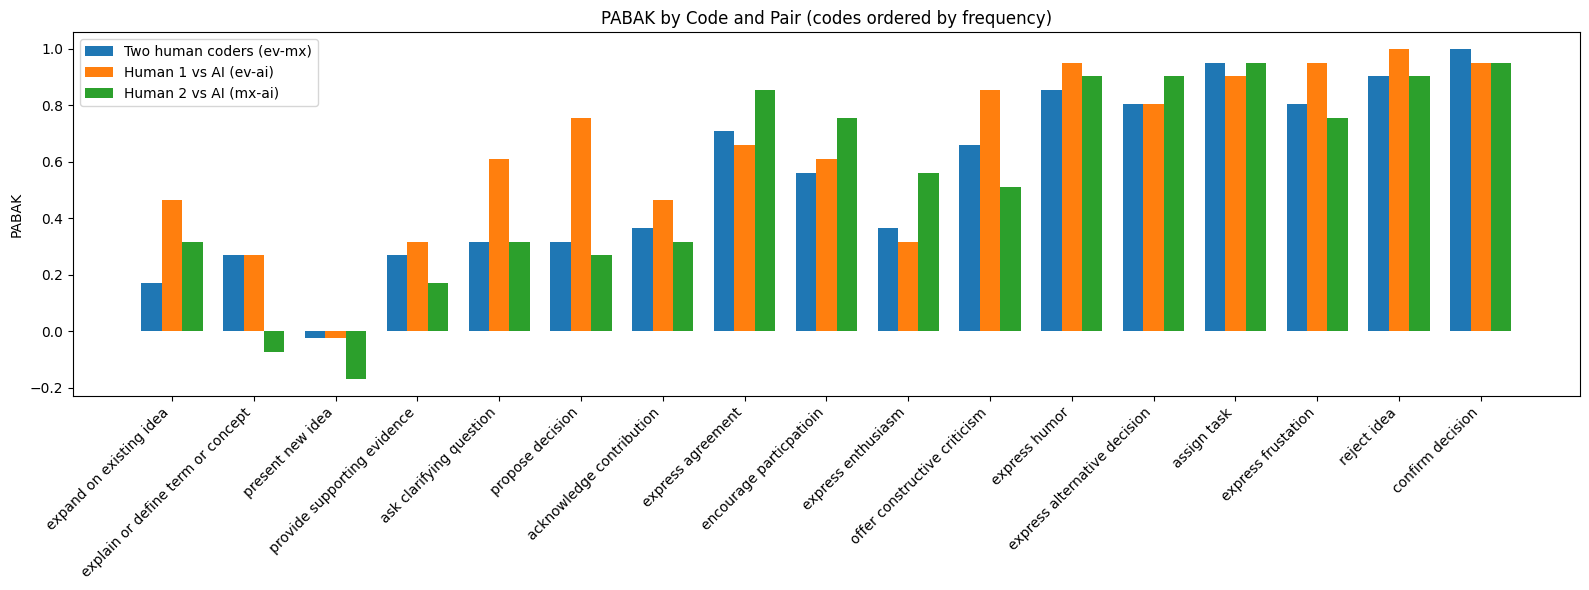

In [ ]:
# Order codes by frequency in filtered_ann_df
code_freq = filtered_ann_df['code'].value_counts()
ordered_codes = code_freq.index.tolist()

# Reindex pabak_table to match this order
pabak_table_ordered = pabak_table.set_index('Code').loc[ordered_codes].reset_index()

codes = pabak_table_ordered['Code']
ev_mx = pabak_table_ordered['ev-mx']
ev_ai = pabak_table_ordered['ev-ai']
mx_ai = pabak_table_ordered['mx-ai']

x = np.arange(len(codes))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6)) 

bar1 = ax.bar(x - width, ev_mx, width, label='Two human coders (ev-mx)')
bar2 = ax.bar(x, ev_ai, width, label='Human 1 vs AI (ev-ai)')
bar3 = ax.bar(x + width, mx_ai, width, label='Human 2 vs AI (mx-ai)')

ax.set_xticks(x)
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('PABAK')
ax.set_title('PABAK by Code and Pair (codes ordered by frequency)')
ax.legend()
plt.tight_layout()
plt.show()

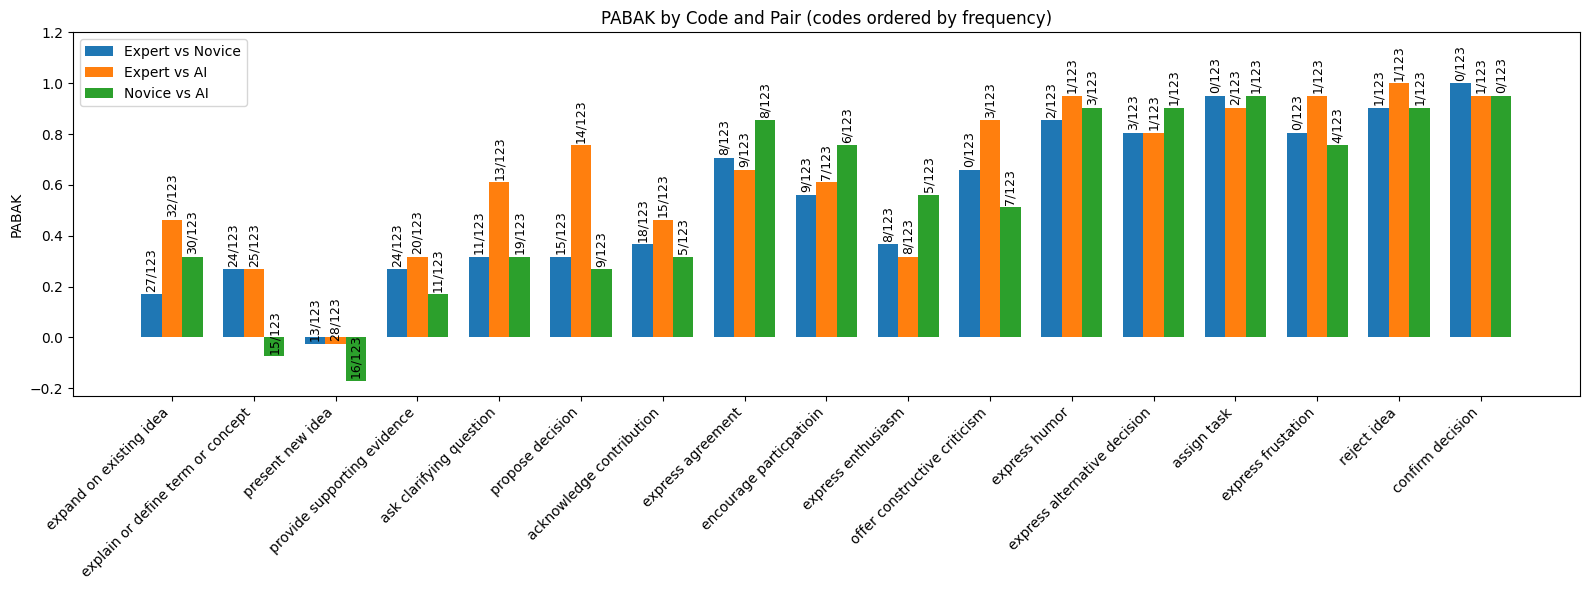

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
codes = pabak_table_ordered['Code']
ev_mx = pabak_table_ordered['ev-mx']
ev_ai = pabak_table_ordered['ev-ai']
mx_ai = pabak_table_ordered['mx-ai']

x = np.arange(len(codes))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6)) 

# Calculate counts for each code and rater
ev_counts = []
mx_counts = []
ai_counts = []
total_ids = filtered_ann_df[['id', 'timestamp']].drop_duplicates().shape[0]

for code in codes:
    ev_count = filtered_ann_df[(filtered_ann_df['coder'] == 'ev') & (filtered_ann_df['code'] == code)]['id'].nunique()
    mx_count = filtered_ann_df[(filtered_ann_df['coder'] == 'mx') & (filtered_ann_df['code'] == code)]['id'].nunique()
    ai_count = filtered_ann_df[(filtered_ann_df['coder'] == 'gemini') & (filtered_ann_df['code'] == code)]['id'].nunique()
    ev_counts.append(ev_count)
    mx_counts.append(mx_count)
    ai_counts.append(ai_count)

# Plot bars
bar1 = ax.bar(x - width, ev_mx, width, label='Expert vs Novice')
bar2 = ax.bar(x, ev_ai, width, label='Expert vs AI')
bar3 = ax.bar(x + width, mx_ai, width, label='Novice vs AI')

# Annotate bars with counts
for i in range(len(codes)):
    # ev-mx bar
    ax.text(x[i] - width, ev_mx[i] + 0.01, f"{ev_counts[i]}/{total_ids}", ha='center', va='bottom', fontsize=9, rotation=90)
    # ev-ai bar
    ax.text(x[i], ev_ai[i] + 0.01, f"{ai_counts[i]}/{total_ids}", ha='center', va='bottom', fontsize=9, rotation=90)
    # mx-ai bar
    ax.text(x[i] + width, mx_ai[i] + 0.01, f"{mx_counts[i]}/{total_ids}", ha='center', va='bottom', fontsize=9, rotation=90)

ax.set_xticks(x)
ax.set_xticklabels(codes, rotation=45, ha='right')
ax.set_ylabel('PABAK')
max_height = max(max(ev_mx), max(ev_ai), max(mx_ai))
ax.set_ylim(top=max_height + 0.2)
ax.set_title('PABAK by Code and Pair (codes ordered by frequency)')
ax.legend()
plt.tight_layout()
plt.show()

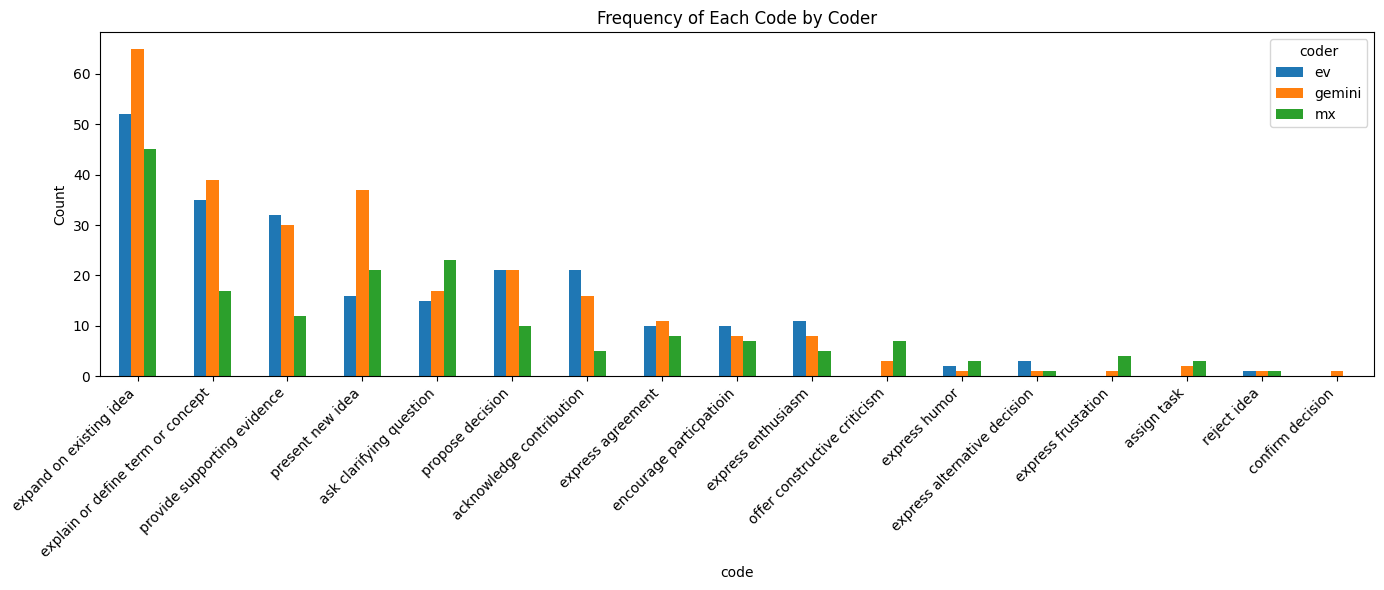

In [108]:
import matplotlib.pyplot as plt

# Count how often each code is used by each coder
code_counts = filtered_ann_df.groupby(['coder', 'code']).size().unstack(fill_value=0)

# Rank codes by total count (sum across coders)
code_order = code_counts.sum(axis=0).sort_values(ascending=False).index

# Plot with ranked codes
ax = code_counts[code_order].T.plot(kind='bar', figsize=(14, 6))
ax.set_ylabel('Count')
ax.set_title('Frequency of Each Code by Coder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()